In [7]:
import imutils
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt

In [8]:
def plot_images(img1, img2, gray=False):
    plt.figure(figsize=(20,10))

    plt.subplot(1, 2, 1)
    if gray:
        plt.imshow(img1, cmap='gray')
    else:
        plt.imshow(img1)

    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    if gray:
        plt.imshow(img2, cmap='gray')
    else:
        plt.imshow(img2)

    plt.title('Mask')
    plt.axis('off')

    plt.show()

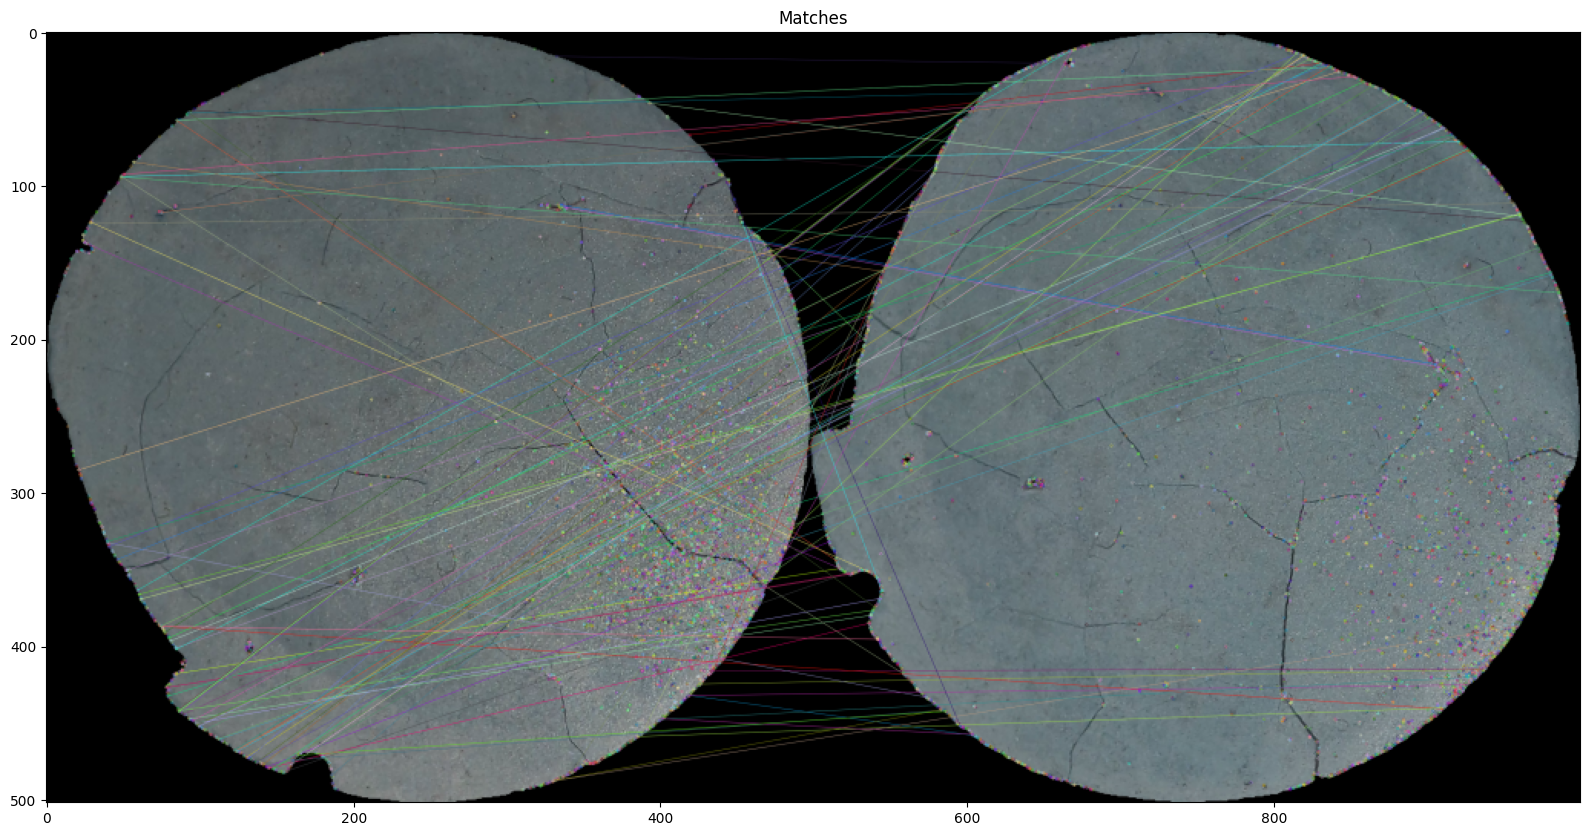

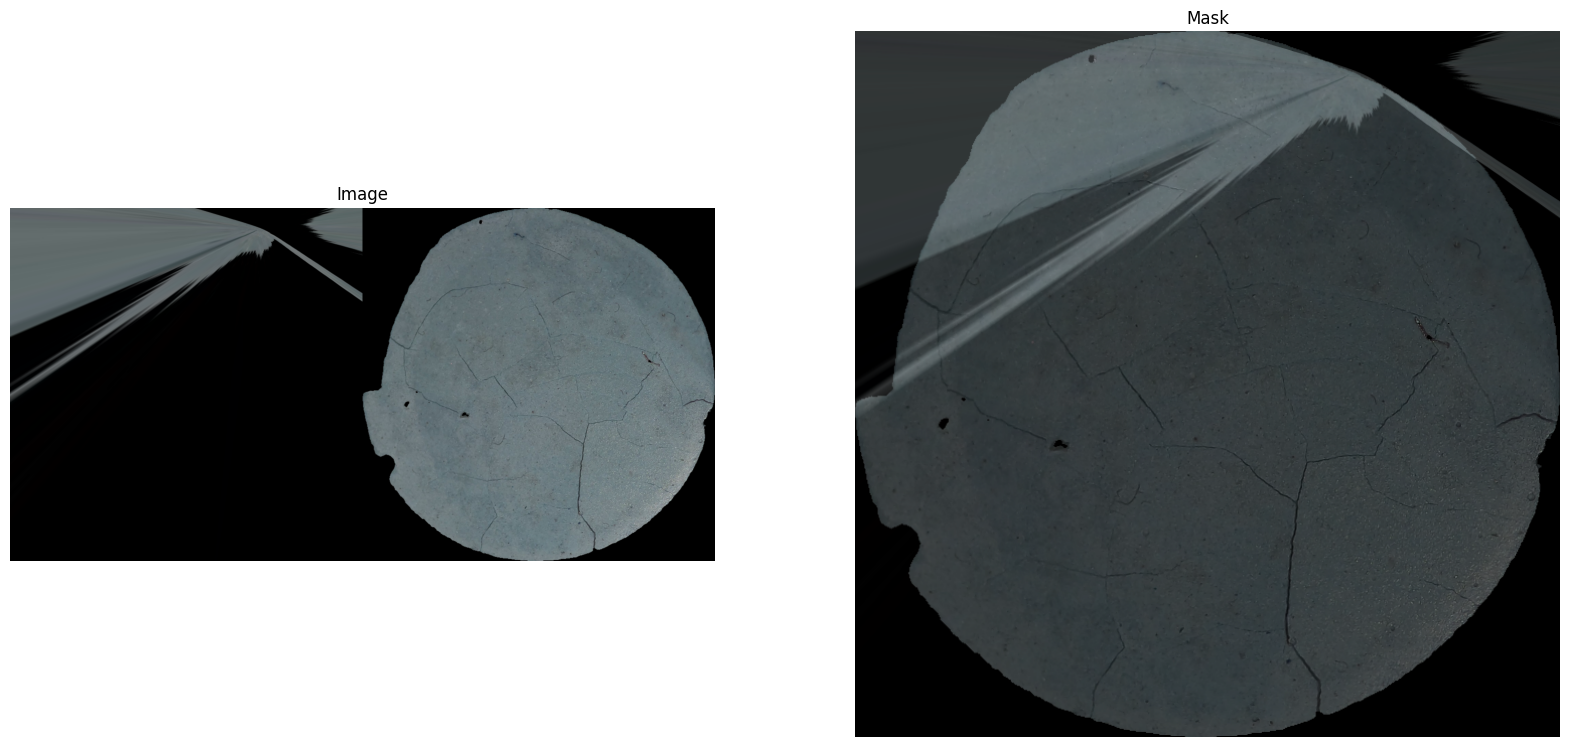

In [38]:
def align_images(image, template, maxFeatures=10000, keepPercent=0.05, debug=False):
    imgGray = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    templateGray = cv.cvtColor(template, cv.COLOR_BGR2RGB)
    # imgGray = image
    # templateGray = template

    orb = cv.ORB_create(nfeatures=maxFeatures, scaleFactor=1.2, nlevels=16)
    (kpsA, descA) = orb.detectAndCompute(imgGray, None)
    (kpsB, descB) = orb.detectAndCompute(templateGray, None)

    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descA, descB)

    matches = sorted(matches, key=lambda x: x.distance)

    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]

    if debug:
        matchedVis = cv.drawMatches(image, kpsA, template, kpsB, matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        plt.figure(figsize=(20,10))
        plt.imshow(matchedVis)
        plt.title('Matches')
        plt.show()

    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    for (i, m) in enumerate(matches):
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt

    # compute the homography matrix between the two sets of matched
    # points
    H, mask = cv.findHomography(ptsA, ptsB, method=cv.RANSAC)
    # use the homography matrix to align the images
    h,w = template.shape[:2]
    aligned = cv.warpPerspective(image, H, (w, h))
    # return the aligned image
    return aligned

img1 = "./imgs/test-03-cropped.jpg"
img2 = "./imgs/test-05-cropped.jpg"
img1 = cv.imread(img1)
img2 = cv.imread(img2)

aligned = align_images(img1, img2, debug=True)

# resize both the aligned and template images so we can easily
# visualize them on our screen
aligned = imutils.resize(aligned, width=700)
template = imutils.resize(img2, width=700)
stacked = np.hstack([aligned, template])
# our first output visualization of the image
# side-by-side comparison of the output align
# template
stacked = np.hstack([aligned, template])
# our second image alignment visualization will be *overlaying* the
# aligned image on the template, that way we can obtain an idea of
# how good our image alignment is
overlay = template.copy()
output = aligned.copy()
cv.addWeighted(overlay, 0.5, output, 0.5, 0, output)
# show the two output image alignment visualizations

plot_images(stacked, output)